In [1]:
# Global imports
import os
import numpy as np
import pandas as pd
import imageio
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, MaxPooling2D, Flatten, Dense
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import tensorflow_addons as tfa
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from sklearn.model_selection import KFold
import numpy as np
import os
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, Flatten, Dense
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from tqdm import tqdm

d:\Users\herna\miniconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
d:\Users\herna\miniconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you wa

In [2]:
import tensorflow as tf
import librosa
#print(tf.config.list_physical_devices('GPU'))
# Desactivar GPU y forzar uso de CPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

#tf.config.set_visible_devices([], 'GPU')

# Load dataset


In [3]:
import pickle
def load_data(filename):
    """
    Load data from a pickle file.

    Args:
        filename (str): The path to the pickle file.

    Returns:
        dict: The loaded data dictionary.
    """
    with open(filename, 'rb') as file:
        data_dict_loaded = pickle.load(file)
    return data_dict_loaded

filename = "../Data/D3TEC.pkl"
data_dict_loaded = load_data(filename)
# data_dict_loaded

In [4]:
data_dict_loaded[3]

{'Marca temporal': '2023/10/11 1:57:08 p.\xa0m. GMT-6',
 'PHQ-9 Score': 3,
 'Age': 62,
 'Gender': 'Female',
 'Lugar de Residencia': 'San Pedro, Nuevo León',
 'Lugar de Procedencia': nan,
 'Social Class': 'Upper Class',
 'Institution': 'CAABI',
 'Medicine': 'Sertrialina',
 'Physical Condition': 'Estenosis Espinal',
 'Mental Health Condition': 'Ansiedad',
 'Depression Diagnosis (level)': nan,
 'PHQ-Binary': 0,
 'audios': {'sm': {0: {'file_path': 'D:/Github/Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search/D3T3C/D3TEC Dataset/SM-27\\153.wav',
    'waveform': array([-3.4575351e-07, -3.7821010e-06, -4.8473012e-06, ...,
           -7.4757336e-06, -4.6938076e-06, -1.4753023e-06], dtype=float32),
    'sample_rate': 22050,
    'spectrogram': array([[-41.41863 , -35.586212, -42.963806, ..., -50.34841 , -42.829468,
            -59.43257 ],
           [-42.578403, -34.543472, -38.21392 , ..., -37.266647, -38.4431  ,
            -47.42988 ],
           [-4

In [5]:
# Global imports
import os
import numpy as np
import pandas as pd
import imageio
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import tensorflow_addons as tfa
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from sklearn.model_selection import KFold
import numpy as np
import os
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, Flatten, Dense, MaxPooling2D
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from tqdm import tqdm



first_call = True

def generate_image_from_spectrogram(spectrogram):
    global first_call
    # Ensure DPI matches the desired image size and plot dimensions
    dpi = 100
    fig_width, fig_height = 792 / dpi, 252 / dpi
    plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
    librosa.display.specshow(spectrogram, x_axis='time', y_axis='mel', fmax=8000)
    plt.axis('off')

    buf = BytesIO()
    # Save the figure with tight bounding box and no padding, transparency might not be needed
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    img = Image.open(buf).convert('RGB')  # Convert to RGB
    img_array = np.array(img.resize((792, 252)))  # Ensure image size

    if first_call:
        plt.show()
        first_call = False
    plt.close()

    return img_array

class KFoldCNNTester:
    def __init__(self, data_dict, filename):
        self.data_dict = data_dict
        self.filename = filename
        self.mean_acc_per_fold = []
        self.mean_loss_per_fold = []
        self.mean_precision_per_fold = []
        self.kfold_list = []

    def run_kfold_test(self):
        X_train, y_train = self.prepare_data()
        folds_list = [3,5,7,10]
        for fold_it in folds_list:
            acc_per_fold = []
            loss_per_fold = []
            precision_per_fold = []
            batch_size = 1
            no_epochs = 100
            verbosity = 2
            num_folds = fold_it
            kfold = KFold(n_splits=num_folds, shuffle=True)

            fold_no = 1

            for train, test in kfold.split(X_train, y_train):
                model = self.define_model()
                print('------------------------------------------------------------------------')
                print(f'Training for fold {fold_no} of {num_folds} folds...')

                callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.0001)
                print(X_train.shape)
                print(X_train[train].shape)
                history = model.fit(X_train[train], y_train[train], batch_size=batch_size, epochs=no_epochs, verbose=verbosity, callbacks=[callback])

                scores = model.evaluate(X_train[test], y_train[test], verbose=1)
                print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%; {model.metrics_names[2]}: {scores[2]}')
                acc_per_fold.append(scores[1] * 100)
                loss_per_fold.append(scores[0])
                precision_per_fold.append(scores[2])

                if scores[1] * 100 > 60:
                    self.save_model_and_data(model, fold_no, scores, num_folds, train)

                fold_no += 1

            self.calculate_means(acc_per_fold, loss_per_fold, precision_per_fold, num_folds)

    def define_model(self):
        model = Sequential([
            BatchNormalization(),
            Conv2D(32, kernel_size=(3, 3), padding='same'),
            LeakyReLU(alpha=0.01),
            BatchNormalization(),
            Conv2D(8, (3, 3), padding='same'),
            LeakyReLU(alpha=0.01),
            BatchNormalization(),
            Conv2D(8, (3, 3), padding='same'),
            LeakyReLU(alpha=0.01),
            BatchNormalization(),
            Conv2D(8, (3, 3), padding='same'),
            LeakyReLU(alpha=0.01),
            Flatten(),
            Dense(64),
            LeakyReLU(alpha=0.01),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.SpecificityAtSensitivity(sensitivity=1)])
        return model

    def save_model_and_data(self, model, fold_no, scores, num_folds, train):
        current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        folder_path = f'{self.filename}_{current_time}/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        subfolder_path = folder_path + f'{num_folds}-fold_{fold_no}-{scores[1]*100}/'
        if not os.path.exists(subfolder_path):
            os.makedirs(subfolder_path)

        model.save(subfolder_path + f'fold-{fold_no}.h5')

    def calculate_means(self, acc_per_fold, loss_per_fold, precision_per_fold, num_folds):
        mean_acc = sum(acc_per_fold) / len(acc_per_fold)
        mean_loss = sum(loss_per_fold) / len(loss_per_fold)
        mean_precision = sum(precision_per_fold) / len(precision_per_fold)
        self.mean_acc_per_fold.append(mean_acc)
        self.mean_loss_per_fold.append(mean_loss)
        self.mean_precision_per_fold.append(mean_precision)
        self.kfold_list.append(num_folds)

        current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        folder_path = f'{self.filename}_{current_time}/'
        with open(folder_path + 'score.txt', 'w') as file:
            file.write(f'accuracy: {mean_acc}. loss: {mean_loss}. precision: {mean_precision}')

    def prepare_data(self):
        X = []
        y = []
        
        total_participants = len(self.data_dict)
        with tqdm(total=total_participants, desc='Preparing Data') as pbar:
            for participant_id, info in self.data_dict.items():
                for audio_type, audios in info['audios'].items():
                    for question_number, audio_data in audios.items():
                        if isinstance(question_number, int):  # Ensure it is a question number
                            #print(question_number)
                            #print(audio_data.keys())
                            spectrogram = audio_data['mel_spectrogram']
                            spectrogram_image = generate_image_from_spectrogram(spectrogram)
                            X.append(spectrogram_image)
                            y.append(info['PHQ-Binary'])
                pbar.update(1)
        
        X = np.array(X)
        y = np.array(y)
        X = X / 255.0  # Normalize the images
        X = np.expand_dims(X, axis=-1)  # Add channel dimension
        
        return X, y



In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

# Placeholder lists for spectrograms and PHQ-Binary scores
X = []
y = []

# Iterate through each participant in the loaded dictionary
for participant_id, participant_data in data_dict_loaded.items():
    # Check if the required keys exist to avoid KeyError
    if 'audios' in participant_data and 'sm' in participant_data['audios'] and len(participant_data['audios']['sm']) > 1:
        if 'mel_spectrogram' in participant_data['audios']['sm'][1]:
            # Append the mel spectrogram to X
            X.append(participant_data['audios']['sm'][1]['mel_spectrogram'])
            # Append the PHQ-Binary score to y
            y.append(participant_data['PHQ-Binary'])

# Convert lists to numpy arrays for easier handling
X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now, X_train, X_test, y_train, and y_test are ready for model training and evaluation

In [7]:
data_dict_loaded[3]['audios']['sm'][0]['mel_spectrogram']

array([[-40.634106, -33.86161 , -28.991337, ..., -21.105831, -26.049225,
        -32.44297 ],
       [-35.003166, -26.70584 , -27.204758, ..., -21.13854 , -26.835445,
        -31.702892],
       [-31.182224, -23.361237, -18.331165, ..., -25.515476, -32.138554,
        -36.998253],
       ...,
       [-79.39004 , -68.098114, -62.51927 , ..., -80.      , -80.      ,
        -80.      ],
       [-76.811134, -65.04663 , -59.945858, ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -72.96848 , -68.72852 , ..., -80.      , -80.      ,
        -80.      ]], dtype=float32)

In [8]:
len(data_dict_loaded.keys())

62

Preparing Data:   0%|          | 0/62 [00:00<?, ?it/s]

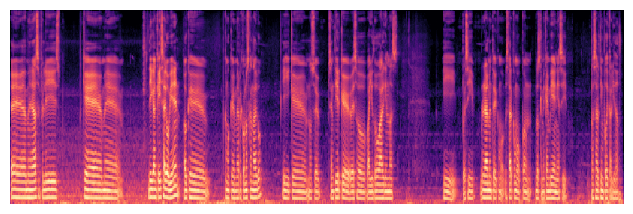

Preparing Data: 100%|██████████| 62/62 [07:03<00:00,  6.83s/it]


------------------------------------------------------------------------
Training for fold 1 of 3 folds...
(3348, 252, 792, 3, 1)
(2232, 252, 792, 3, 1)
Epoch 1/100
2232/2232 - 268s - loss: 4.6742 - accuracy: 0.4942 - precision: 0.4585 - specificity_at_sensitivity: 0.0000e+00 - 268s/epoch - 120ms/step
Epoch 2/100
2232/2232 - 265s - loss: 0.7626 - accuracy: 0.5040 - precision: 0.4680 - specificity_at_sensitivity: 0.0000e+00 - 265s/epoch - 119ms/step
Epoch 3/100
2232/2232 - 259s - loss: 1.2647 - accuracy: 0.5143 - precision: 0.4796 - specificity_at_sensitivity: 0.0000e+00 - 259s/epoch - 116ms/step
Epoch 4/100


In [9]:
import tensorflow as tf
#tf.config.set_visible_devices([], 'GPU')  # Desactivar GPU

# Rest of your code remains the same

# Instantiate the KFoldCNNTester class
tester = KFoldCNNTester(data_dict_loaded, filename)

# Run the K-Fold test
tester.run_kfold_test()